## Importing Libraries

In [0]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import tensorflow as tf

import seaborn as sns
from pylab import rcParams

from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42

## Setting up of the data

In [0]:
LABELS = ["Normal", "Fraud"]

df = pd.read_csv("data/creditcard.csv")

print(df.shape)

# Checking for any null values
df.isnull().values.any()

(284807, 31)


False

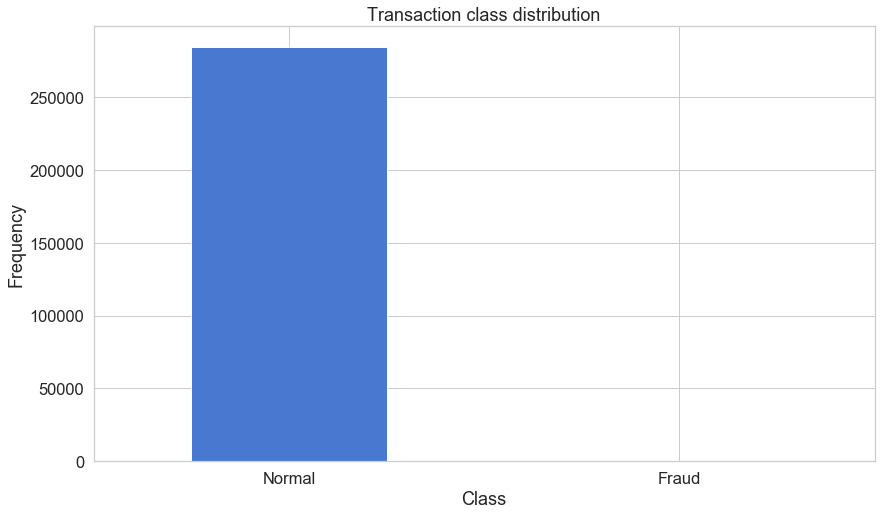

In [0]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [0]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

frauds.shape
normal.shape

(284315, 31)

<Figure size 864x576 with 0 Axes>

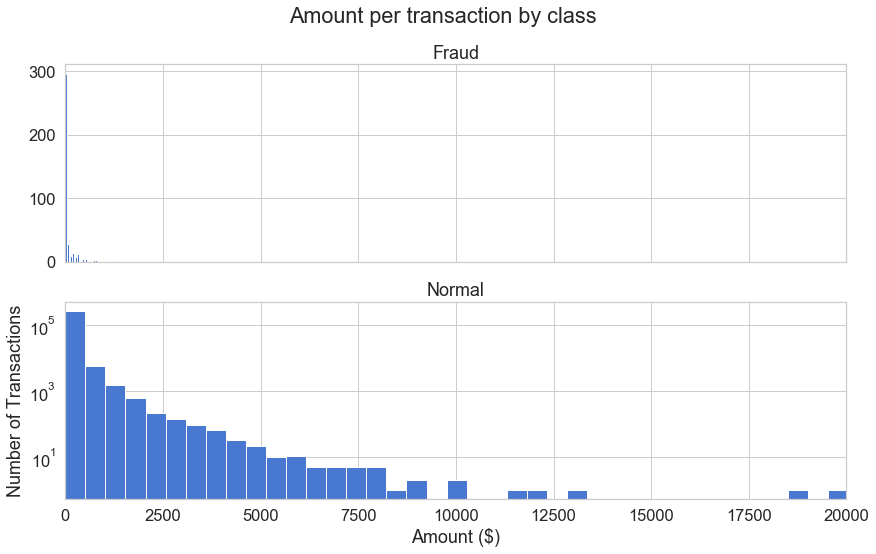

In [0]:
# Distribution of fraud/normal amount 

frauds.Amount.describe()
normal.Amount.describe()

plt.figure(figsize=(12,8))
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();


In [0]:
## Data Pre-processing - Scaling

In [0]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

# Setting up X_train, removing the 'Class variable' 
# We wont be using fraud cases.
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

# For testing
y_test = X_test['Class']

X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(227451, 29)

## Modeling

In [0]:
input_dim = X_train.shape[1]   # 29
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))  #29

encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(encoding_dim, activation='tanh')(encoder)

decoder = Dense(input_dim, activation='relu')(decoder)   #29

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [0]:
nb_epoch = 1
batch_size = 32

In [0]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

**NOTE: Input and output is same as X_train and for validation it is X_test**

In [0]:
autoencoder.fit(X_train, X_train,       
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1)

Train on 227451 samples, validate on 56962 samples
Epoch 1/1
227451/227451 [==============================] - 7s 30us/step - loss: 0.7882 - acc: 0.6078 - val_loss: 0.7683 - val_acc: 0.6433


In [0]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.768336,0.001720
std,3.548135,0.041443
min,0.058925,0.000000
25%,0.247398,0.000000
50%,0.395614,0.000000
75%,0.636481,0.000000
max,259.019309,1.000000


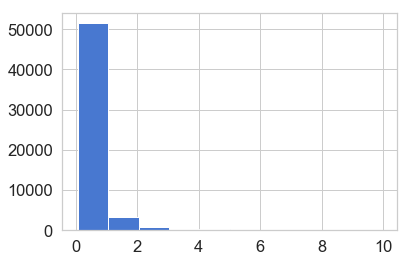

In [0]:
# Reconstruction error without fraud

fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

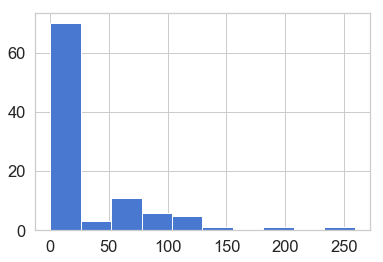

In [0]:
# Reconstruction error with fraud

fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [0]:
threshold = 2.9

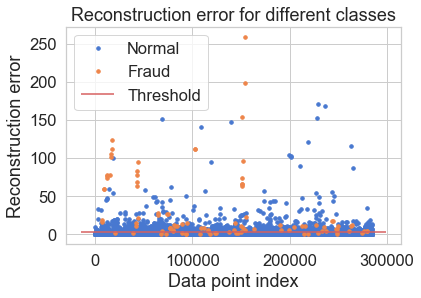

In [0]:
groups = error_df.groupby('true_class')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
    
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [0]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

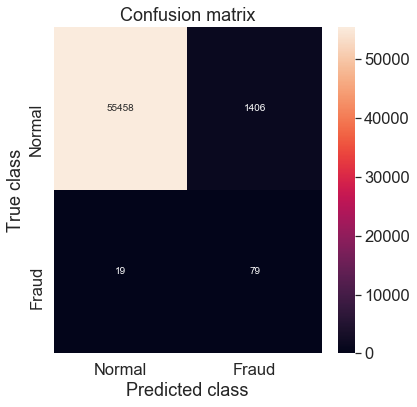

In [0]:
from sklearn.metrics import confusion_matrix
                             
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
                             
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()